# Penultimate-Fed Gaussian Process (PFGP)
The penultimate layer of a trained CGCNN model is fed to a GP to predict uncertainties

# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


model_name = 'CFGP'

with open('../../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Define all the adsorbates
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

# Parse CGCNN results

Initialize the CGCNN `net` class and then load the model we fit in `../NN`

In [3]:
from torch.optim import Adam
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)

net.initialize()
net.load_params(f_history='../../NN/gasdb_pooled/valid_best_history.json',
                f_optimizer= '../../NN/gasdb_pooled/valid_best_optimizer.pt', 
                f_params='../../NN/gasdb_pooled/valid_best_params.pt')

Get and scale the penultimate output of CGCNN. We cache just to save time

In [4]:
%load_ext ipycache

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [5]:
%%cache conv.pkl conv_train conv_val conv_test scaler input_train input_val input_test targets_train targets_val targets_test

from sklearn.preprocessing import StandardScaler


# Grab the penultimate layer
%time _, conv_train = net.forward(sdts_train)
%time _, conv_val = net.forward(sdts_val)
%time _, conv_test = net.forward(sdts_test)

# Scale them
scaler = StandardScaler()
input_train = torch.Tensor(scaler.fit_transform(conv_train)).contiguous()
input_val = torch.Tensor(scaler.transform(conv_val))
input_test = torch.Tensor(scaler.transform(conv_test))

# Format the output, too
targets_train = torch.Tensor(targets_train.reshape(-1))
targets_val = torch.Tensor(targets_val.reshape(-1))
targets_test = torch.Tensor(targets_test.reshape(-1))

[Skipped the cell's code and loaded variables conv_test, conv_train, conv_val, input_test, input_train, input_val, scaler, targets_test, targets_train, targets_val from file '/global/cfs/cdirs/m2755/ktran/sandbox/uncertainty_benchmarking/CFGP/Matern/conv.pkl'.]
CPU times: user 7.89 s, sys: 271 ms, total: 8.16 s
Wall time: 6.21 s
CPU times: user 1.53 s, sys: 25.5 ms, total: 1.55 s
Wall time: 1.14 s
CPU times: user 2.03 s, sys: 14.2 ms, total: 2.04 s
Wall time: 1.51 s


# Training GP
We tried using an exact GP with a CPU, but it took too long and never converged. We then tried an exact GP with a GPU, but we did not have enough memory in the GPU to hold both the data and the kernel. Finally, we tried using 3 GPUs (each with 16 GB of memory). This finally worked.

In order to use 3 GPUs, we needed to run a Python script instead of a Jupyter notebook (because of logistical reasons on our high-performance computers). Here is what that python script contains:

```
import gc
import pickle
import numpy as np
import torch
import gpytorch
from LBFGS import FullBatchLBFGS


# Verify the number of GPUs
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))
output_device = torch.device('cuda:0')

# Pull training data
with open('../../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)
with open('../../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)
docs_train, docs_val = splits['docs_train'], splits['docs_val']
sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

# Load CGCNN outputs
with open('penult.pkl', 'rb') as file_handle:
    cache = pickle.load(file_handle)
penult_train = cache['penult_train']
penult_val = cache['penult_val']
scaler = cache['scaler']
input_train = cache['input_train']
input_val = cache['input_val']
targets_train = cache['targets_train']
targets_val = cache['targets_val']

# Make the targets contiguous...?
targets_train, targets_val = targets_train.contiguous(), targets_val.contiguous()
# Move them to the GPU
input_train, targets_train = input_train.to(output_device), targets_train.to(output_device)
input_val, targets_val = input_val.to(output_device), targets_val.to(output_device)


# Define GP
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Define training routine
def train(train_x, train_y,
          n_devices, output_device,
          checkpoint_size, preconditioner_size,
          n_training_iter):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
    model = ExactGPModel(train_x, train_y, likelihood, n_devices).to(output_device)
    model.train()
    likelihood.train()

    optimizer = FullBatchLBFGS(model.parameters(), lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    with gpytorch.beta_features.checkpoint_kernel(checkpoint_size), \
         gpytorch.settings.max_preconditioner_size(preconditioner_size):

        def closure():
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            return loss

        loss = closure()
        loss.backward()

        for i in range(n_training_iter):
            options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
            loss, _, _, _, _, _, _, fail = optimizer.step(options)

            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, n_training_iter, loss.item(),
                model.covar_module.module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))

            if fail:
                print('Convergence reached!')
                break

    print(f"Finished training on {train_x.size(0)} data points using {n_devices} GPUs.")
    return model, likelihood


# Define routine for getting GPU settings
def find_best_gpu_setting(train_x, train_y,
                          n_devices, output_device,
                          preconditioner_size):
    N = train_x.size(0)

    # Find the optimum partition/checkpoint size by decreasing in powers of 2
    # Start with no partitioning (size = 0)
    settings = [0] + [int(n) for n in np.ceil(N / 2**np.arange(1, np.floor(np.log2(N))))]

    for checkpoint_size in settings:
        print('Number of devices: {} -- Kernel partition size: {}'.format(n_devices, checkpoint_size))
        try:
            # Try a full forward and backward pass with this setting to check memory usage
            _, _ = train(train_x, train_y,
                         n_devices=n_devices, output_device=output_device,
                         checkpoint_size=checkpoint_size,
                         preconditioner_size=preconditioner_size, n_training_iter=1)

            # when successful, break out of for-loop and jump to finally block
            break
        except RuntimeError as e:
            print('RuntimeError: {}'.format(e))
        except AttributeError as e:
            print('AttributeError: {}'.format(e))
        finally:
            # handle CUDA OOM error
            gc.collect()
            torch.cuda.empty_cache()
    return checkpoint_size


# Set a large enough preconditioner size to reduce the number of CG iterations run
preconditioner_size = 100
checkpoint_size = find_best_gpu_setting(input_train, targets_train,
                                        n_devices=n_devices,
                                        output_device=output_device,
                                        preconditioner_size=preconditioner_size)

# Fit and save the model
model, likelihood = train(input_train, targets_train,
                          n_devices=n_devices, output_device=output_device,
                          checkpoint_size=10000,
                          preconditioner_size=100,
                          n_training_iter=20)
torch.save(model.state_dict(), 'model_state.pth')

# Make and save the predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    preds = model(input_val)
targets_pred = preds.mean
targets_std = preds.stddev.detach().cpu().numpy()
residuals = (targets_pred - targets_val).detach().cpu().numpy()
with open('predictions.pkl', 'wb') as file_handle:
    pickle.dump((residuals, targets_std), file_handle)
```

And here is the output:
```
Planning to run on 3 GPUs.
Number of devices: 3 -- Kernel partition size: 0
Iter 1/1 - Loss: 0.168   lengthscale: 3.747   noise: 0.035
Finished training on 32359 data points using 3 GPUs.
Iter 1/20 - Loss: 0.164   lengthscale: 3.768   noise: 0.034
Iter 2/20 - Loss: 0.175   lengthscale: 3.768   noise: 0.034
Convergence reached!
Finished training on 32359 data points using 3 GPUs.
```

Now we load the model

In [6]:
import torch
import gpytorch


# Verify the number of GPUs
n_devices = torch.cuda.device_count()
output_device = torch.device('cuda:0')


# Define GP
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_devices):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

        self.covar_module = gpytorch.kernels.MultiDeviceKernel(
            base_covar_module, device_ids=range(n_devices),
            output_device=output_device
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Instantiate GP
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
model = ExactGPModel(input_train, targets_train, likelihood, n_devices).to(output_device)

# Load the state
state_dict = torch.load('model_state.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

# Assess performance
## Validation
We used the results in this section to tune hyperparameters

In [16]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.78
PPMCC = 0.89


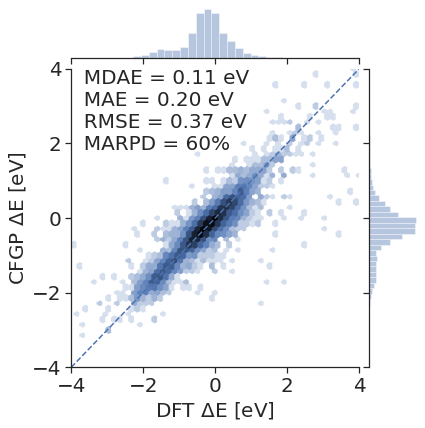

In [17]:
import pickle
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Load the results
with open('predictions.pkl', 'rb') as file_handle:
    residuals, stdevs = pickle.load(file_handle)

# Parse the predictions
targets_pred = targets_val.numpy().reshape(-1) + residuals

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.detach().cpu().numpy().reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

In [18]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the lower
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    upper_bound = norm.ppf(percentile)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

calibration_error = ((predicted_pi - observed_pi)**2).sum()
print('Calibration error = %.2f' % calibration_error)

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Calibration error = 0.10


In [19]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

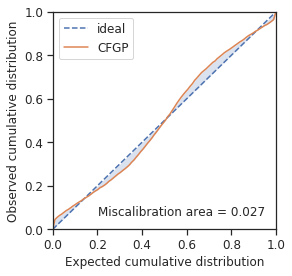

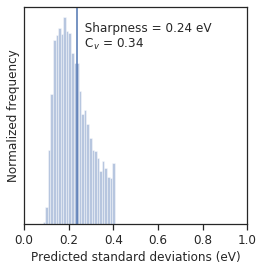

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected cumulative distribution')
_ = ax_ideal.set_ylabel('Observed cumulative distribution')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
dispersion = np.sqrt(((stdevs - stdevs.mean())**2).sum() / (len(stdevs)-1)) / stdevs.mean()
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV\n  C$_v$ = %.2f' % (sharpness, dispersion)
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  \nC$_v$ = %.2f  ' % (sharpness, dispersion)
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

## Test
We never actually made the predictions during the job, so we have to make the predictions here.

In [23]:
import torch


# Verify the number of GPUs
n_devices = torch.cuda.device_count()
print('Planning to run on {} GPUs.'.format(n_devices))
output_device = torch.device('cuda:0')

# Put the model into evaluation mode, and then make the predictions
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.beta_features.checkpoint_kernel(1000):
    _input_test = input_test.contiguous().to(output_device)
    %time preds = model(_input_test)
targets_pred = preds.mean.detach().cpu().numpy()
stdevs = preds.stddev.detach().cpu().numpy()
residuals = targets_pred - targets_test.detach().cpu().numpy()

# Save test results
with open('test_predictions.pkl', 'wb') as file_handle:
    pickle.dump((residuals, stdevs), file_handle)

Planning to run on 1 GPUs.
CPU times: user 34.5 s, sys: 9.52 s, total: 44 s
Wall time: 44.3 s


In [24]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.80
PPMCC = 0.90


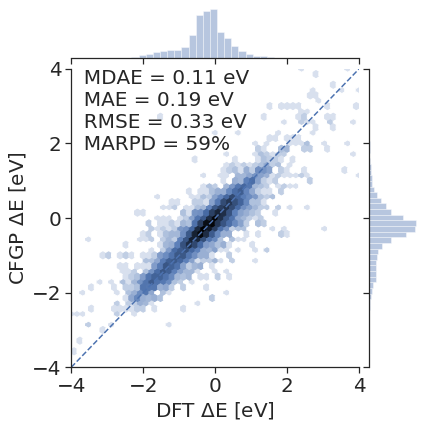

In [25]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_test, targets_pred))
mdae = median_absolute_error(targets_test, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_test.detach().cpu().numpy().reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_test, targets_pred)
corr = np.corrcoef(targets_test.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [26]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the lower
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    upper_bound = norm.ppf(percentile)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

calibration_error = ((predicted_pi - observed_pi)**2).sum()
print('Calibration error = %.2f' % calibration_error)

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Calibration error = 0.13


In [27]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

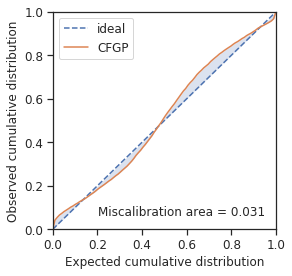

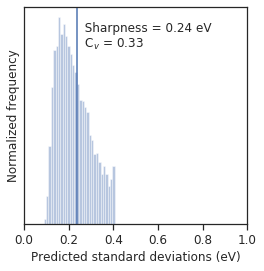

In [28]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected cumulative distribution')
_ = ax_ideal.set_ylabel('Observed cumulative distribution')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Save
plt.savefig('calibration.pdf', dpi=300, bbox_inches='tight', transparent=True)


# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness/dispersion
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
dispersion = np.sqrt(((stdevs - stdevs.mean())**2).sum() / (len(stdevs)-1)) / stdevs.mean()
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV\n  C$_v$ = %.2f' % (sharpness, dispersion)
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  \nC$_v$ = %.2f  ' % (sharpness, dispersion)
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

# Save
plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [37]:
from scipy.stats import norm


nll_list = []
for (res, std) in zip(residuals, stdevs):
    nll_list.append(norm.logpdf(res, scale=std))

nll = -1 * np.sum(nll_list)

print('NLL = {}'.format(nll))

NLL = 2781.4027126344035


## Results-by-adsorbate
Let's dig into details and see how our results turned out for each adsorbate. Note that this section shows the results from a single model trained on a pooled dataset. Only the performance metrics are partitioned by adsorbate.

In [38]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np


class SeabornFig2Grid():
    '''
    Credit goes to ImportanceOfBeingErnest on StackOverflow
    https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
    '''

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

For CO:
    R2 = 0.81
    PPMCC = 0.90
For H:
    R2 = 0.61
    PPMCC = 0.79
For N:
    R2 = 0.70
    PPMCC = 0.84
For O:
    R2 = 0.78
    PPMCC = 0.88
For OH:
    R2 = 0.82
    PPMCC = 0.91


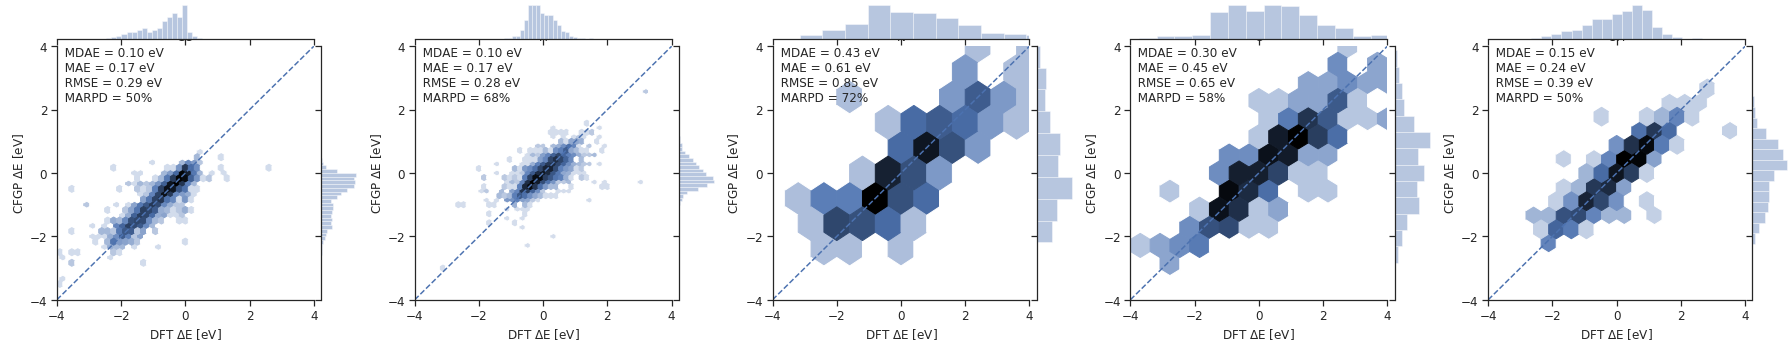

In [39]:
%matplotlib inline
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Prepare figure for all adsorbates
fig = plt.figure(figsize=(25, 5))
gs = gridspec.GridSpec(1, len(adsorbates))

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _targets_test = []
    _targets_pred = []
    for doc, target, pred in zip(docs_test, targets_test, targets_pred):
        if doc['adsorbate'] == ads:
            _targets_test.append(target)
            _targets_pred.append(pred)
    _targets_test = np.array(_targets_test).reshape(-1)
    _targets_pred = np.array(_targets_pred).reshape(-1)
    _residuals = _targets_pred - _targets_test

    # Plot accuracy
    lims = [-4, 4]
    grid = sns.jointplot(_targets_test, _targets_pred,
                         kind='hex',
                         bins='log',
                         extent=lims*2)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_xticks([-4,-2, 0, 2, 4])
    _ = ax.set_yticks([-4,-2, 0, 2, 4])
    _ = ax.set_xlabel('DFT $\Delta$E [eV]')
    _ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)
    _ = ax.set_title(ads)

    # Calculate metrics
    mae = mean_absolute_error(_targets_test, _targets_pred)
    rmse = np.sqrt(mean_squared_error(_targets_test, _targets_pred))
    mdae = median_absolute_error(_targets_test, _targets_pred)
    marpd = np.abs(2 * _residuals /
                   (np.abs(_targets_pred) + np.abs(_targets_test))
                   ).mean() * 100
    r2 = r2_score(_targets_test, _targets_pred)
    corr = np.corrcoef(_targets_test, _targets_pred)[0, 1]

    # Report
    text = ('  MDAE = %.2f eV\n' % mdae + 
            '  MAE = %.2f eV\n' % mae + 
            '  RMSE = %.2f eV\n' % rmse + 
            '  MARPD = %i%%\n' % marpd)
    print('For %s:' % ads)
    print('    R2 = %.2f' % r2)
    print('    PPMCC = %.2f' % corr)
    _ = ax.text(x=lims[0], y=lims[1], s=text,
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=fontsize)

    # Put the figure into the subplot
    sfg = SeabornFig2Grid(grid, fig, gs[i])
gs.tight_layout(fig)

# Save figure
plt.savefig('parity_blocked.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [40]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile, residuals, stdevs):
    '''
    Calculate the fraction of the residuals that fall within the lower
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    upper_bound = norm.ppf(percentile)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


# Initialize the information we need to make calibration plots
predicted_pi = {}
observed_pi = {}

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _residuals = []
    _stdevs = []
    for doc, resid, se in zip(docs_val, residuals, stdevs):
        if doc['adsorbate'] == ads:
            _residuals.append(resid)
            _stdevs.append(se)
    _residuals = np.array(_residuals).reshape(-1)
    _stdevs = np.array(_stdevs).reshape(-1)

    # Calculate the prediction intervals
    _predicted_pi = np.linspace(0, 1, 100)
    _observed_pi = [calculate_density(quantile, _residuals, _stdevs)
                    for quantile in tqdm_notebook(_predicted_pi, desc='Calibration')]

    # Store the information
    predicted_pi[ads] = _predicted_pi
    observed_pi[ads] = _observed_pi

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


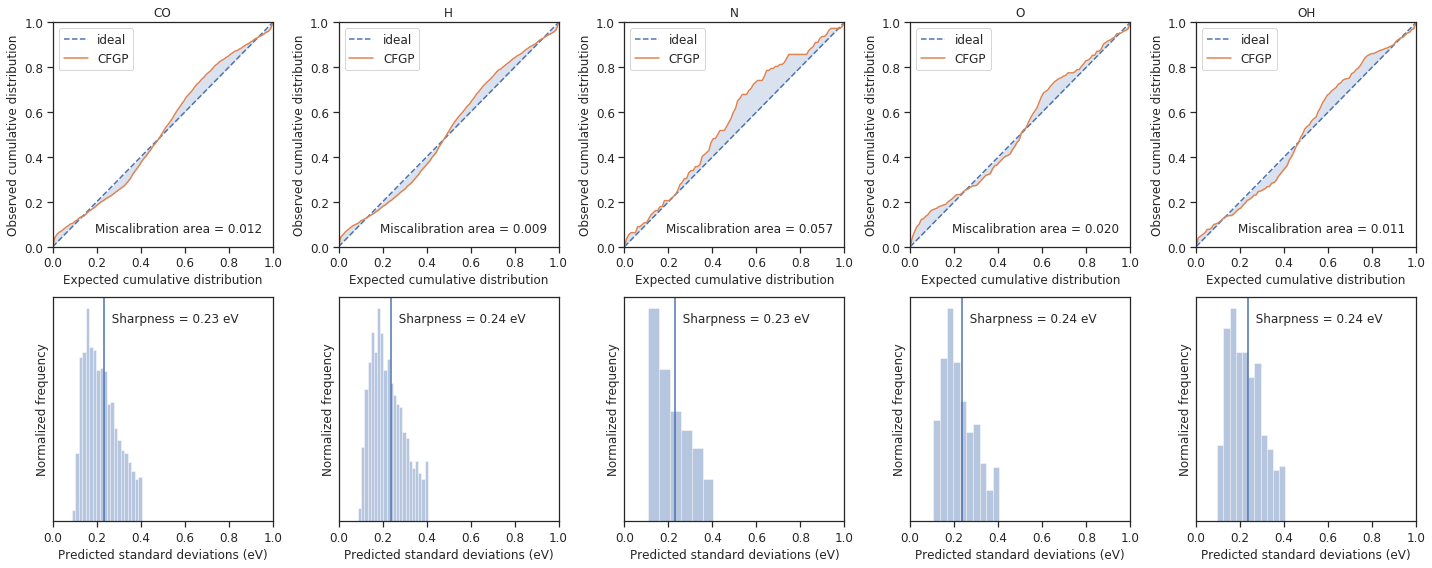

In [41]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from shapely.geometry import Polygon


# Prepare figure for all adsorbates
figsize = (20, 8)
fig, axes = plt.subplots(2, len(adsorbates), figsize=figsize)
sub_figsize = (figsize[0]/len(adsorbates), figsize[1]/2)


# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _stdevs = []
    for doc, stdev in zip(docs_val, stdevs):
        if doc['adsorbate'] == ads:
            _stdevs.append(stdev)
    _stdevs = np.array(_stdevs).reshape(-1)
    _observed_pi = observed_pi[ads]
    _predicted_pi = predicted_pi[ads]

    # Plot the calibration curve
    ax_cal = axes[0][i]
    ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal', ax=ax_cal)
    _ = ax_ideal.lines[0].set_linestyle('--')
    ax_gp = sns.lineplot(_predicted_pi, _observed_pi, label=model_name, ax=ax_cal)
    ax_fill = ax_cal.fill_between(_predicted_pi, _predicted_pi, _observed_pi,
                                  alpha=0.2)
    _ = ax_ideal.set_xlabel('Expected cumulative distribution')
    _ = ax_ideal.set_ylabel('Observed cumulative distribution')
    _ = ax_ideal.set_xlim([0, 1])
    _ = ax_ideal.set_ylim([0, 1])
    _ = ax_cal.legend(loc='upper left')
    _ = ax_cal.set_title(ads)

    # Calculate the miscalibration area.
    polygon_points = []
    for point in zip(_predicted_pi, _observed_pi):
        polygon_points.append(point)
    for point in zip(reversed(_predicted_pi), reversed(_predicted_pi)):
        polygon_points.append(point)
    polygon_points.append((_predicted_pi[0], _observed_pi[0]))
    polygon = Polygon(polygon_points)
    miscalibration_area = polygon.area

    # Annotate the plot with the miscalibration area
    ax_cal.text(x=0.95, y=0.05,
                s='Miscalibration area = %.3f' % miscalibration_area,
                verticalalignment='bottom',
                horizontalalignment='right',
                fontsize=fontsize)

    # Plot sharpness curve
    xlim = [0., 1.]
    ax_sharp = axes[1][i]
    ax_sharp = sns.distplot(_stdevs, kde=False, norm_hist=True, ax=ax_sharp)
    ax_sharp.set_xlim(xlim)
    ax_sharp.set_xlabel('Predicted standard deviations (eV)')
    ax_sharp.set_ylabel('Normalized frequency')
    ax_sharp.set_yticklabels([])
    ax_sharp.set_yticks([])

    # Calculate and report sharpness
    sharpness = np.sqrt(np.mean(_stdevs**2))
    _ = ax_sharp.axvline(x=sharpness, label='sharpness')
    if sharpness < (xlim[0] + xlim[1]) / 2:
        text = '\n  Sharpness = %.2f eV' % sharpness
        h_align = 'left'
    else:
        text = '\nSharpness = %.2f eV  ' % sharpness
        h_align = 'right'
    _ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                      s=text,
                      verticalalignment='top',
                      horizontalalignment=h_align,
                      fontsize=fontsize)

# Save figure
fig.tight_layout()
plt.savefig('calibration_and_sharpness_blocked.pdf', dpi=300, bbox_inches='tight', transparent=True)

# Error-bar figure
We concede that calibration curves and sharpness distributions are new concepts in the field of catalysis, and that a simple parity plot with error bars is more intuitive. As such, we create a few examples of error bar parities to help readers connect those incumbent ideas with the newer ideas of calibration and sharpness.

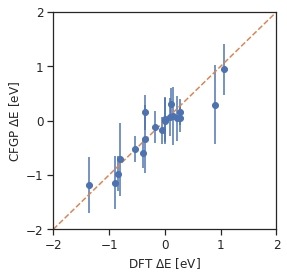

In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Pull a random sample of the data, because plotting thousands of these at once would look absurd
all_predictions = list(zip(targets_pred, targets_test.reshape(-1), stdevs))
samples = random.sample(all_predictions, k=20)

# Parse the samples
_preds, _targets, _stdevs = zip(*samples)
_preds = np.array(_preds)
_targets = np.array(_targets)
_stdevs = np.array(_stdevs)

# Plot
fig = plt.figure(figsize=(4, 4))
_ = plt.errorbar(_targets, _preds, yerr=2*_stdevs, fmt='o')
ax = plt.gca()

# Make a parity line
lims = [-2, 2]
_ = ax.plot(lims, lims, '--')

# Format
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.set_xticks(list(range(-2, 3)))
_ = ax.set_yticks(list(range(-2, 3)))
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Save
_ = plt.savefig('error_bar_parity.pdf', dpi=300, bbox_inches='tight', transparent=True)